In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from efficient_kan.src.efficient_kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import (create_and_delay_pulse_pair, create_position, set_seed, 
                       calculate_gaussian_center_sigma, plot_gaussian, get_gaussian_params)

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data = np.load(os.path.join(dir,'Na22_train_interpolated.npz'))['data']
val_data = np.load(os.path.join(dir, 'Na22_val_interpolated.npz'))['data']
test_data = np.load(os.path.join(dir, 'Na22_test_val_interpolated.npz'))['data']

In [4]:
class ConvolutionalModel(nn.Module):
    def __init__(self, N_rows, N_columns):
        super(ConvolutionalModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d((2, 2)) # Output: (batch_size, 8, N_rows // 2, N_columns // 2)

        # Calculate the flattened size after the convolutions and pooling
        self.flatten_size = 16 * (N_rows // 2) * (N_columns // 2)  # Adjust according to pooling layers
        
        self.fc1 = nn.Linear(self.flatten_size, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
                
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc1(x)
     
        return x    

In [5]:
def custom_loss(outputs_0, outputs_1, labels):
    loss = (torch.mean(abs(outputs_0 - outputs_1 - labels)) +
            torch.sum(torch.relu(-outputs_0)) +
            torch.sum(torch.relu(-outputs_1)))
    return loss


def train_loop_convolutional(model, optimizer, train_loader, val_loader, test_tensor, EPOCHS = 75, checkpoint = 15, name = 'model', save = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    test_tensor = test_tensor.to(device)
    
    loss_list = []
    val_loss_list = []
    test = []

    # Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

    for epoch in range(EPOCHS):
        running_loss = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()

            # Make predictions for this batch 
            outputs_0 = model(inputs[:, None, :, :, 0])
            outputs_1 = model(inputs[:, None, :, :, 1])

            # Compute the loss and its gradients
            loss = custom_loss(outputs_0, outputs_1, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            # Accumulate running loss
            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Calculate average loss per epoch
        avg_loss_epoch = running_loss / (i)  
        loss_list.append(avg_loss_epoch)

        print(f'EPOCH {epoch + 1}: LOSS train {avg_loss_epoch}')

        # Calculate predictions on test_tensor
        model.eval()
        with torch.no_grad():
            test_epoch = model(test_tensor[:, None, :, :])
            test.append(np.squeeze(test_epoch.cpu().numpy()))

            val_loss = 0
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val_0 = model(val_data[:, None, :, :, 0])
                val_1 = model(val_data[:, None, :, :, 1])
                val_loss += custom_loss(val_0, val_1, val_labels)
        val_loss_list.append(val_loss.cpu().numpy() / len(val_loader))
        print(f'LOSS val {val_loss / len(val_loader)}')


        if save and (epoch + 1) % checkpoint == 0:
            model_name = f'{name}_{epoch + 1}.pth'
            torch.save(model.state_dict(), model_name)

    # Convert lists to numpy arrays
    loss_array = np.array(loss_list, dtype = 'object')
    test = np.array(test, dtype = 'object')
    val = np.array(val_loss_list, dtype = 'object')
    
    return loss_array, test, val

In [6]:
# Important definitions
time_step = 0.025 #Already interpolated
delay_steps = 30  # Max number of steps to delay pulses
nbins = 91  # Num bins for all histograms                          
t_shift = 8  # Time steps to move for the new positions
EXTRASAMPLING = 8
start = 40*EXTRASAMPLING
stop = 84*EXTRASAMPLING
set_seed(42) #Fix seeds
epochs = 500
lr = 1e-4

In [7]:
train_data = train_data[:,start:stop,:]
validation_data = val_data[:,start:stop,:]
test_data = test_data[:,start:stop,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  18000
Número de casos de test:  3075


In [8]:
train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,:,0], time_step, delay_steps = delay_steps, NOISE = True)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,:,1], time_step, delay_steps = delay_steps, NOISE = True)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(validation_data[:,:,0], time_step, delay_steps = delay_steps, NOISE = False)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(validation_data[:,:,1], time_step, delay_steps = delay_steps, NOISE = False)

TEST_00 = test_data
TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)  
TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)

# **SPECTOGRAMS**

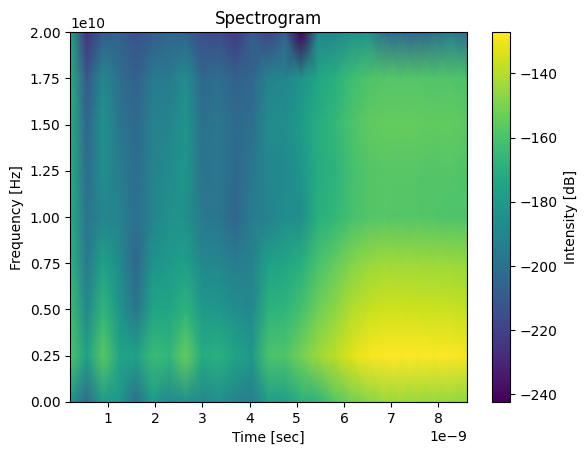

In [9]:
from scipy import signal

fs = 40*(10**9) # Sample frequency in hz (40Gsamples/s for my interpoalted data)
nperseg = 16
# Calculate sample spectrogram
f, t, Sxx = signal.spectrogram(train_dec0[0,:,0], fs, nperseg = nperseg)
Sxx_db = 10 * np.log10(Sxx) # In decibel scale

# Plot
plt.pcolormesh(t, f, Sxx_db, shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label = 'Intensity [dB]')
plt.show()

In [10]:
spectogram_train_dec0 = np.zeros((train_dec0.shape[0], Sxx.shape[0], Sxx.shape[1], 2))
spectogram_train_dec1 = np.zeros((train_dec1.shape[0], Sxx.shape[0], Sxx.shape[1], 2))

spectogram_val_dec0 = np.zeros((val_dec0.shape[0], Sxx.shape[0], Sxx.shape[1], 2))
spectogram_val_dec1 = np.zeros((val_dec1.shape[0], Sxx.shape[0], Sxx.shape[1], 2))

spectogram_test = np.zeros((TEST.shape[0], Sxx.shape[0], Sxx.shape[1], 2))

# Fill training spectograms
for i in range(train_dec0.shape[0]):

    f_chn0, t_chn0, Sxx_chn0_dec0 = signal.spectrogram(train_dec0[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec0 = signal.spectrogram(train_dec0[i, :, 1], fs, nperseg = nperseg)
    
    f_chn0, t_chn0, Sxx_chn0_dec1 = signal.spectrogram(train_dec1[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec1 = signal.spectrogram(train_dec1[i, :, 1], fs, nperseg = nperseg)

    spectogram_train_dec0[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec0) # In decibel scale
    spectogram_train_dec0[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec0) 
    spectogram_train_dec1[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec1) 
    spectogram_train_dec1[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec1) 

# Fill validation spectograms
for i in range(val_dec0.shape[0]):

    f_chn0, t_chn0, Sxx_chn0_dec0 = signal.spectrogram(val_dec0[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec0 = signal.spectrogram(val_dec0[i, :, 1], fs, nperseg = nperseg)
    
    f_chn0, t_chn0, Sxx_chn0_dec1 = signal.spectrogram(val_dec1[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec1 = signal.spectrogram(val_dec1[i, :, 1], fs, nperseg = nperseg)

    spectogram_val_dec0[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec0) # In decibel scale
    spectogram_val_dec0[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec0) 
    spectogram_val_dec1[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec1) 
    spectogram_val_dec1[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec1) 

# Fill test spectograms
for i in range(TEST.shape[0]):

    f_chn0, t_chn0, Sxx_chn0 = signal.spectrogram(TEST[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1 = signal.spectrogram(TEST[i, :, 1], fs, nperseg = nperseg)
    
    spectogram_test[i, :, :, 0] = 10 * np.log10(Sxx_chn0) # In decibel scale
    spectogram_test[i, :, :, 1] = 10 * np.log10(Sxx_chn1) 

In [11]:
# Create Dataset / DataLoaders
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

val_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_val_dec0).float(), torch.from_numpy(np.expand_dims(REF_val_dec0, axis = -1)).float())
val_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_val_dec1).float(), torch.from_numpy(np.expand_dims(REF_val_dec1, axis = -1)).float())

train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

val_loader_dec0 = torch.utils.data.DataLoader(val_dataset_dec0, batch_size = 32, shuffle = False)
val_loader_dec1 = torch.utils.data.DataLoader(val_dataset_dec1, batch_size = 32, shuffle = False)

# **MODEL**

In [12]:
# Initialize model
model_dec0 = ConvolutionalModel(spectogram_train_dec0.shape[1], spectogram_train_dec0.shape[2])
model_dec1 = ConvolutionalModel(spectogram_train_dec1.shape[1], spectogram_train_dec1.shape[2])

# Initialize optimizer
optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr)
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr)

In [13]:
# Execute train loop
loss_dec0, test_dec0, val_dec0 = train_loop_convolutional(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(spectogram_test[:,:,:,0]).float(), EPOCHS = epochs, save = False) 
loss_dec1, test_dec1, val_dec1 = train_loop_convolutional(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(spectogram_test[:,:,:,1]).float(), EPOCHS = epochs, save = False) 

EPOCH 1: LOSS train 0.7059180773662078
LOSS val 0.23174862563610077
EPOCH 2: LOSS train 0.19539068285309547
LOSS val 0.1926340013742447
EPOCH 3: LOSS train 0.13122275042152065
LOSS val 0.1385858803987503
EPOCH 4: LOSS train 0.08240654696030973
LOSS val 0.1026267409324646
EPOCH 5: LOSS train 0.06820053181667345
LOSS val 0.08606786280870438
EPOCH 6: LOSS train 0.05920332314917201
LOSS val 0.07283250987529755
EPOCH 7: LOSS train 0.05089096059803967
LOSS val 0.05941249430179596
EPOCH 8: LOSS train 0.04332635053218047
LOSS val 0.049372993409633636
EPOCH 9: LOSS train 0.037252454259482565
LOSS val 0.03940297290682793
EPOCH 10: LOSS train 0.03220579861679854
LOSS val 0.03453582897782326
EPOCH 11: LOSS train 0.02873808771597215
LOSS val 0.030004417523741722
EPOCH 12: LOSS train 0.02557240146812171
LOSS val 0.027176508679986
EPOCH 13: LOSS train 0.02327249619904309
LOSS val 0.023372285068035126
EPOCH 14: LOSS train 0.020932535642552524
LOSS val 0.021443719044327736
EPOCH 15: LOSS train 0.019118

In [14]:
TOF_V02 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
TOF_V00 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
TOF_V20 = test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]
TOF_V04 = test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]
TOF_V40 = test_dec0[:,4*TEST_00.shape[0]:] - test_dec1[:,4*TEST_00.shape[0]:]

# Calulate Validation error
centroid_V00, sigma_V00 = calculate_gaussian_center_sigma(TOF_V00, np.zeros((TOF_V00.shape[0])), nbins = nbins) 
    
error_V02 = abs((TOF_V02 - centroid_V00[:, np.newaxis] + time_step*t_shift))
error_V00 = abs((TOF_V00 - centroid_V00[:, np.newaxis]))
error_V20 = abs((TOF_V20 - centroid_V00[:, np.newaxis] - time_step*t_shift))
error_V04 = abs((TOF_V04 - centroid_V00[:, np.newaxis] + 2*time_step*t_shift))
error_V40 = abs((TOF_V40 - centroid_V00[:, np.newaxis] - 2*time_step*t_shift))

# Get MAE
Error = np.concatenate((error_V02, error_V20, error_V00, error_V04, error_V40), axis = 1)   
MAE = np.mean(Error, axis = 1)
print(MAE[-1])

0.08018440588529077


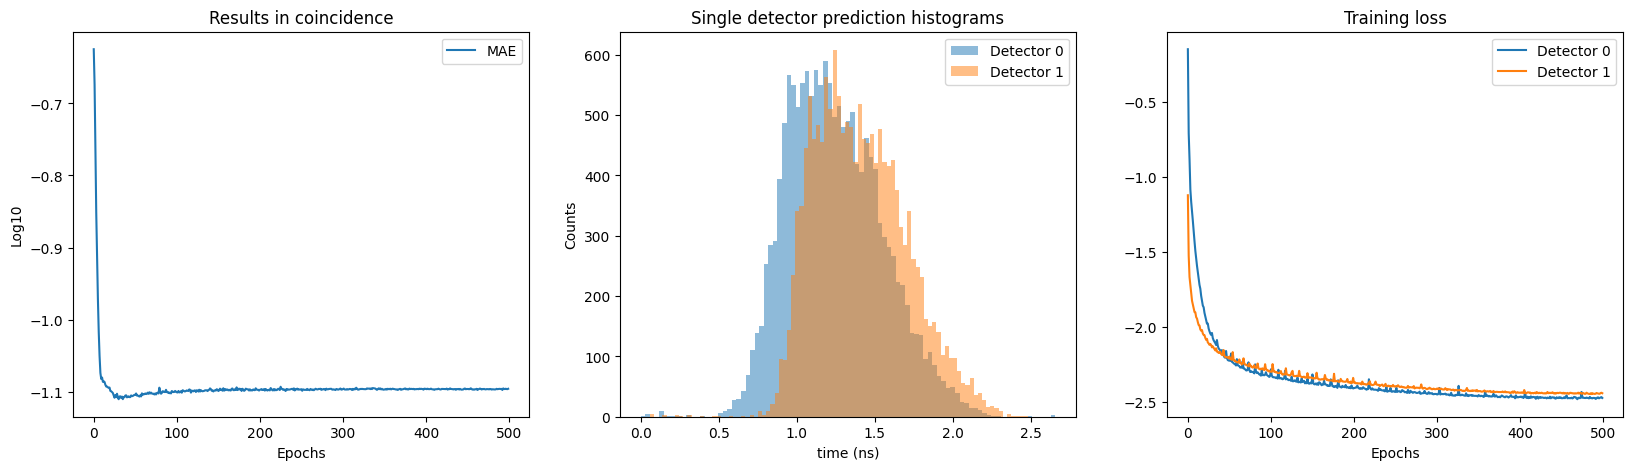

In [15]:
# Plot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE.astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
plt.hist(test_dec0[-1,:], bins = nbins, alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1,:], bins = nbins, alpha = 0.5, label = 'Detector 1');
plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

V40: CENTROID(ns) = 0.3996 +/- 0.00107  FWHM(ns) = 0.2166 +/- 0.00115
V20: CENTROID(ns) = 0.2019 +/- 0.00113  FWHM(ns) = 0.2184 +/- 0.00121
V00: CENTROID(ns) = -0.0000 +/- 0.00099  FWHM(ns) = 0.2174 +/- 0.00106
V02: CENTROID(ns) = -0.1999 +/- 0.00102  FWHM(ns) = 0.2183 +/- 0.00109
V04: CENTROID(ns) = -0.3989 +/- 0.00115  FWHM(ns) = 0.2167 +/- 0.00123



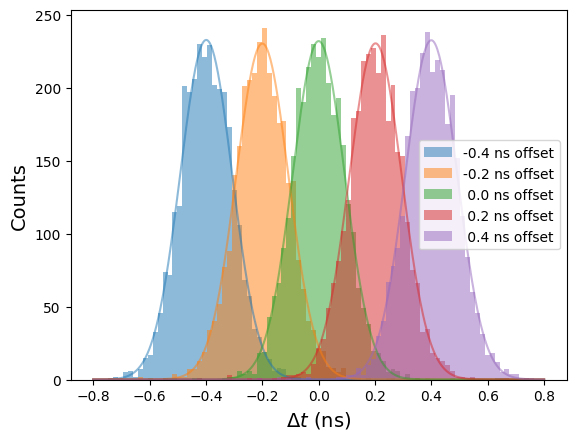

In [18]:
# Histogram and gaussian fit 
plot_gaussian(TOF_V04[-1,:], centroid_V00[-1], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
plot_gaussian(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V40[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.4 ns offset', nbins = nbins)


params_V04, errors_V04 = get_gaussian_params(TOF_V04[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V02, errors_V02 = get_gaussian_params(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V40, errors_V40 = get_gaussian_params(TOF_V40[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()

# EN COINCIDENCIAS

usar ya desplazados, mas rapido